# **Data Preprocessing: Stage Two**

1.	Splitting the training data (windowed under sampling):
-	Get the durations for all the species
-	From the species with the shortest duration, make 70% of that duration the benchmark for the training duration of all the species for balanced training
-	The remaining samples will be the validation data
-	Normalize the audio samples
-	Turn all the data into windowed Mel-spectrograms (window the audio using half overlap and normalization of spectrograms)
-	Since the audio samples are the same duration, the dimensions of the Mel will be the same
-	(Save that into a pkl file or something for easy access for all the models)



I noticed that the volumes of the samples where very different. 
* I will try first normalizing the volume of all samples between 0 and 1. 
* Then i will convert those to mel spectrograms, and then normalize those between 0 and 1 also between sample

I noticed that the lengths are very different so scaling it by stretching and shrinking the data basically gave the machine nonsense and thats why the accuracy was bad. 

I can try using audio samples that are greater than 2 seconds long, and use a 2 second window and a 1 second overlap to create the spectrograms with each sample, keeping track of the class of the audio sample. This should make all the spectrograms have the same size and surely improve the results a bit. 

I will experiment with different window sizes and save those files in pkl for later. 

* I will do 2 sec with 1 sec overlap
* I will do 4 sec with 2 sec overlap
* I will do 6 sec with 3 sec overlap
* I will do 8 sec with 4 sec overlap

This is just to show how one improvement (overlap) can affect results

### I am going to pad the audio samples with less duration with pink noise. Pink noise is much better than white noise as it sounds more natural

In [5]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import time

# Libraries for audio
from IPython.display import Audio
import librosa
import librosa.display

# Training and Testing Split
from sklearn.model_selection import train_test_split

# for normalization & avgpooling features
from sklearn.preprocessing import MinMaxScaler # to squeeze all the features to be within 0 and 1
import tensorflow as tf

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
from playsound import playsound
import pygame
import time
from scipy.signal import butter, filtfilt
import random
import IPython.display as ipd

pygame 2.6.1 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [6]:
def play_sound(file_path):
    """
    Plays the sound file specified by file_path.

    Parameters:
        file_path (str): The path to the sound file to be played.
    """
    try:
        pygame.mixer.init()
        pygame.mixer.music.load(file_path)
        pygame.mixer.music.play()
        
        # Keep the program running while the sound is playing
        while pygame.mixer.music.get_busy():
            time.sleep(1)

    except Exception as e:
        print(f"An error occurred: {e}")

# Feature Extraction

Turning the data into Mel-spectrograms 

In [18]:
npy_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V3/train_audio_npy/' 
train_csv = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V3/train.csv' 
annotated_train_csv = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V3/train-annotated.csv'
sr = 22050

In [2]:
save_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V3/feature-extraction/stage-2-1/'  # Where to save Mel spectrograms
n_mels = 128
target_shape = (200,300)
sr = 22050

In [3]:
# Loading the train-validation split CSV
csv_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V3/trainval-split/stage-2-1-trainval.csv'
trainval_data = pd.read_csv(csv_path)
train_data = trainval_data[trainval_data['set'] == 'tr']
val_data = trainval_data[trainval_data['set'] == 'val']

In [4]:
# Function to normalize audio data between 0 and 1
def normalize_audio(audio):
    return (audio - np.min(audio)) / (np.max(audio) - np.min(audio))


In [14]:
def bandpass_filter(audio, lowcut=800, highcut=8000, sr=sr, order=4):
    nyquist = 0.5 * sr  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')
    
    # Apply filter to audio
    filtered_audio = filtfilt(b, a, audio)
    return filtered_audio

In [12]:
def generate_pink_noise(num_samples):
    white_noise = np.random.randn(num_samples)
    
    # Apply a filter to convert white noise into pink noise (1/f noise)
    X = np.fft.rfft(white_noise)
    S = np.arange(1, len(X) + 1)  # Frequency scaling
    pink_noise = np.fft.irfft(X / S)
    
    return normalize_audio(pink_noise)

In [15]:
def avg_pooling_keras(mel_spectrograms):
    """
    Apply average pooling to mel spectrograms using Keras.

    Parameters:
      mel_spectrograms (np.array): Input features of shape (num_samples, n_mels, time_steps)

    Returns:
      np.array: Pooled features of shape (num_samples, n_mels)
    """
    # Clear the previous Keras session
    tf.keras.backend.clear_session()

    # Define the input shape based on features
    input_shape = mel_spectrograms.shape[1:]  # (n_mels, time_steps)

    # Create the Keras model for average pooling
    inputs = tf.keras.layers.Input(shape=input_shape)
    pooled = tf.keras.layers.GlobalAveragePooling1D()(inputs)
    pooling_model = tf.keras.models.Model(inputs=inputs, outputs=pooled)

    # Perform pooling using the model
    pooled_features = pooling_model.predict(mel_spectrograms)

    return pooled_features

In [16]:
def pad_with_noise(audio_data, window_length, sr=sr):
    current_length = librosa.get_duration(y=audio_data, sr=sr)
    if current_length >= window_length:
        return audio_data
    
    target_length_samples = int(window_length * sr) + 1
    current_length_samples = len(audio_data)
    padding_length_samples = target_length_samples - current_length_samples
    
    # Generate pink noise to pad with
    pink_noise = generate_pink_noise(padding_length_samples)
    padded_audio = np.concatenate([audio_data, pink_noise])
    
    return padded_audio

In [17]:
def check_process_audio_file(file_path, label, sr=22050, window_size=6, overlap=0.5, target_shape=(300, 200), normalize=True, average_pooling=False, filter=True):
    audio = np.load(file_path)
    audio = normalize_audio(audio)
    audio = pad_with_noise(audio, window_length=window_size)
    if filter:
            audio = bandpass_filter(audio)

    window_samples = int(window_size * sr)
    hop_samples = int(window_samples * (1 - overlap))  # For overlapping

    # Break the audio into windows with the specified overlap
    audio_windows = librosa.util.frame(audio, frame_length=window_samples, hop_length=hop_samples).T

    features = []

    for idx, window in enumerate(audio_windows):
        # Handle padding for the last window if necessary

        if len(window) < window_samples:
            window = pad_with_noise(window, window_length=window_size)

        # Mel Spectrogram --------------------------------------------------------------------
        mel_spectrogram = librosa.feature.melspectrogram(y=window, sr=sr, n_mels=target_shape[0])
        if normalize:
            mel_spectrogram = librosa.util.normalize(mel_spectrogram)

        zoom_factors = (target_shape[0] / mel_spectrogram.shape[0], target_shape[1] / mel_spectrogram.shape[1])
        mel_spectrogram_resized = scipy.ndimage.zoom(mel_spectrogram, zoom_factors, order=1) 


        # Chroma feature ----------------------------------------------------------
        chroma = librosa.feature.chroma_stft(y=window, sr=sr, n_chroma=12)
        if normalize:
            chroma = librosa.util.normalize(chroma)
        
        # Resize the chroma feature to fit target shape
        chroma_resized = scipy.ndimage.zoom(chroma, (target_shape[0] / chroma.shape[0], target_shape[1] / chroma.shape[1]), order=1)
        
        # MFCC feature ------------------------------------------------------------
        mfcc = librosa.feature.mfcc(y=window, sr=sr, n_mfcc=20)
        if normalize:
            mfcc = librosa.util.normalize(mfcc)

        # Resize the MFCC feature to fit the target shape
        mfcc_resized = scipy.ndimage.zoom(mfcc, (target_shape[0] / mfcc.shape[0], target_shape[1] / mfcc.shape[1]), order=1)

        # Stack the features together for this window
        combined_features = np.stack([mel_spectrogram_resized, chroma_resized, mfcc_resized], axis=-1)

        features.append(combined_features)

    features = np.array(features)

    # Apply average pooling if requested
    if average_pooling:
        pooled_features = avg_pooling_keras(features)
        return {'features': pooled_features, 'label': label}

    # If not using average pooling, return resized features
    return {'features': features, 'label': label}

In [19]:
def process_dataset(df, sr=22050, window_size=6, overlap=0.5, target_shape=(300, 200), normalize=True, average_pooling=False, save_path=''):
    processed_data = []

    # Loop over each audio file in the dataframe
    for index, row in tqdm(df.iterrows(), desc="Processing data"):
        file_path = row['filename_npy']
        label = row['species'] 
        
        # Process each audio file and add to the list
        audio_data = check_process_audio_file(
            npy_path + file_path, 
            label, 
            sr=sr, 
            window_size=window_size, 
            overlap=overlap, 
            target_shape=target_shape, 
            normalize=normalize, 
            average_pooling=average_pooling
        )
        processed_data.append(audio_data)

    # Add a new column to the dataframe with the processed spectrogram data
    df['processed_features'] = processed_data

    # Return the updated dataframe
    return df

# **Plotting Before Processing All**

In [20]:
def plot_spectrogram(spectrogram_data, window_index, window_size, file_path, sr=22050):
    if window_index < 0 or window_index >= len(spectrogram_data['features']):
        raise IndexError("Invalid window index. Please choose a valid index.")
    
    # Extracting the combined features for the selected window (Mel spectrogram, Chroma, MFCC)
    selected_features = spectrogram_data['features'][window_index]
    
    mel_spectrogram = selected_features[:, :, 0]  # Mel spectrogram
    chroma = selected_features[:, :, 1]           # Chroma
    mfcc = selected_features[:, :, 2]             # MFCC
    
    audio = np.load(file_path)
    
    window_samples = int(window_size * sr)
    hop_samples = int(window_samples * (1 - 0.5))
    start_index = window_index * hop_samples
    end_index = start_index + window_samples
    
    if end_index > len(audio):
        end_index = len(audio)
        start_index = max(0, end_index - window_samples)

    audio_segment = audio[start_index:end_index]
    
    # Plot the Mel spectrogram, Chroma, and MFCC in separate subplots
    plt.figure(figsize=(15, 20))
    
    # Mel spectrogram plot
    plt.subplot(3, 1, 1)
    plt.imshow(mel_spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram (Window {window_index})')
    plt.xlabel('Time Frames')
    plt.ylabel('Mel Frequency Bins')

    # Chroma plot
    plt.subplot(3, 1, 2)
    plt.imshow(chroma, aspect='auto', origin='lower', cmap='coolwarm')
    plt.colorbar(format='%+2.0f')
    plt.title(f'Chroma (Window {window_index})')
    plt.xlabel('Time Frames')
    plt.ylabel('Chroma Bins')

    # MFCC plot
    plt.subplot(3, 1, 3)
    plt.imshow(mfcc, aspect='auto', origin='lower', cmap='inferno')
    plt.colorbar(format='%+2.0f')
    plt.title(f'MFCC (Window {window_index})')
    plt.xlabel('Time Frames')
    plt.ylabel('MFCC Coefficients')

    plt.tight_layout()
    plt.show()

    # Play the corresponding audio segment
    return Audio(audio_segment, rate=sr)

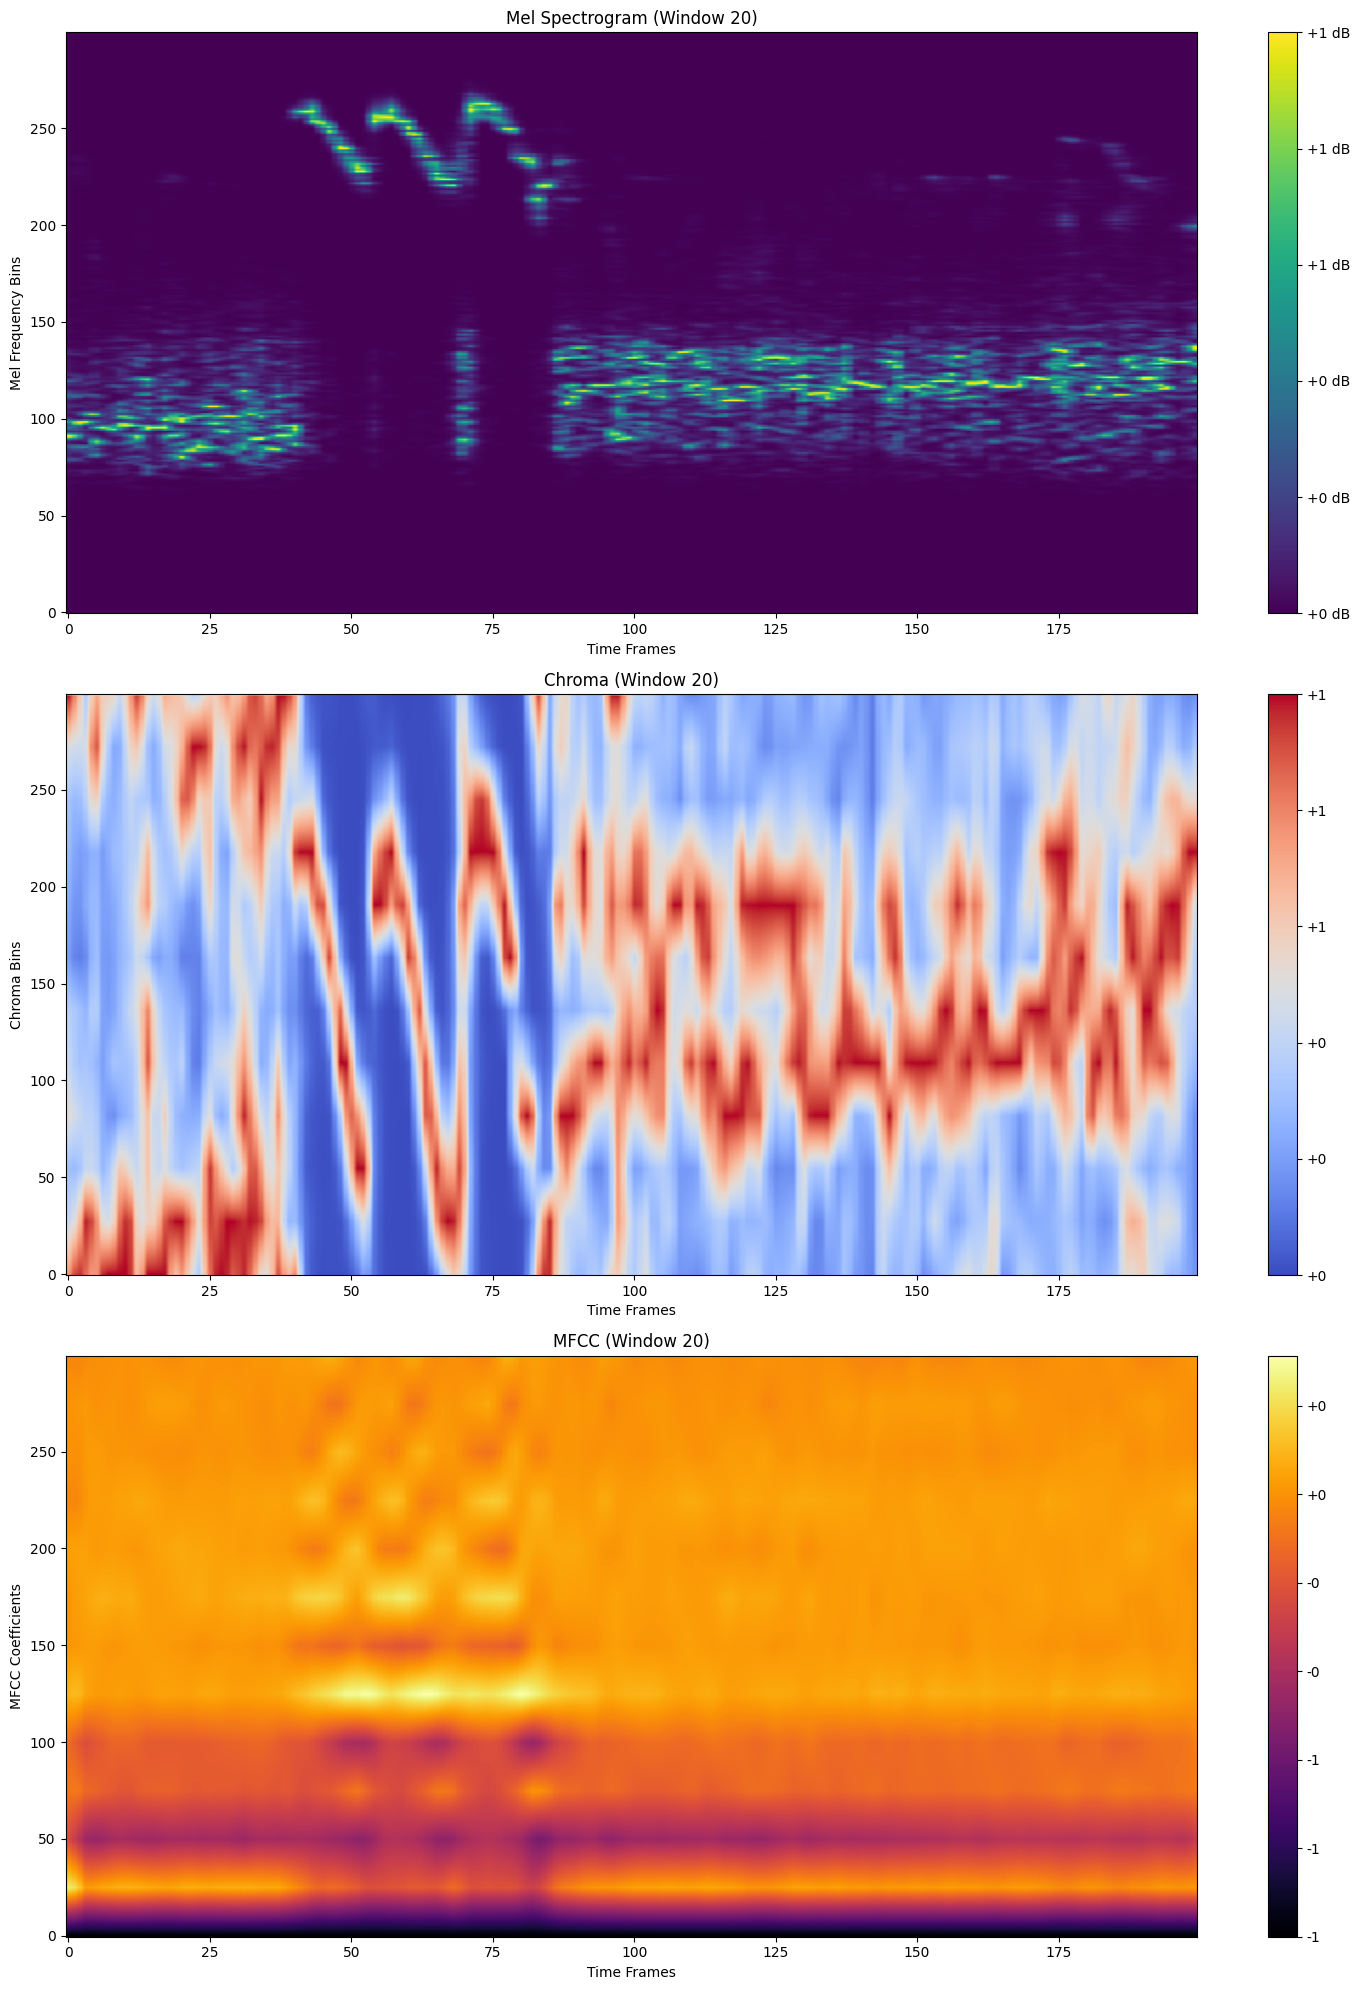

In [21]:
file_path = 'Motacilla flava/XC252756.npy'
label = 'Motacilla flava'

example_path = npy_path + file_path

spectrogram_data = check_process_audio_file(example_path, label, window_size=3, overlap=0.5)

window_index_to_plot = 20
audio_widget = plot_spectrogram(spectrogram_data, window_index_to_plot, window_size=3, file_path=example_path)
display(audio_widget)

# **Processing the training data**

In [ ]:
processed_train_data = process_dataset(
    train_data,
    window_size=6,
    overlap=0.5,
    target_shape=(300, 200),
    normalize=True,
    average_pooling=False,
    save_path=save_path
)

Processing data: 483it [08:28,  1.05s/it]
C:\Users\thato\AppData\Local\Temp\ipykernel_19012\3271826754.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_spectrograms'] = processed_data


In [ ]:
processed_train_data.head()

,Unnamed: 0,species,audio_name,duration,filename_npy,set,processed_spectrograms
0,542,Fulica atra,XC504105.mp3,74.202041,Fulica atra/XC504105.npy,tr,{'features': [[[[ 3.45461357e-03 2.81875355e-...
1,562,Fulica atra,XC548458.mp3,11.853787,Fulica atra/XC548458.npy,tr,{'features': [[[[ 2.01279696e-03 7.86764336e-...
2,550,Fulica atra,XC538144.mp3,10.381678,Fulica atra/XC538144.npy,tr,{'features': [[[[ 1.32586967e-01 7.20314414e-...
3,563,Fulica atra,XC548770.mp3,35.738005,Fulica atra/XC548770.npy,tr,{'features': [[[[ 7.34869327e-04 2.62249643e-...
4,559,Fulica atra,XC543771.mp3,3.059002,Fulica atra/XC543771.npy,tr,{'features': [[[[ 5.51799884e-03 2.52135763e-...


In [ ]:
train_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V3/feature-extraction/stage-2-1/6s-2D-MS-train.pkl'
with open(train_pkl_path, 'wb') as f:
    pickle.dump(processed_train_data, f)

In [ ]:
del f

## Processing the validation data

In [ ]:
processed_val_data = process_dataset(
    val_data,
    window_size=6,
    overlap=0.5,
    target_shape=(300, 200),
    normalize=True,
    average_pooling=False,
    save_path=save_path
)

Processing data: 132it [01:46,  1.23it/s]
C:\Users\thato\AppData\Local\Temp\ipykernel_19012\3271826754.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_spectrograms'] = processed_data


In [ ]:
val_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V3/feature-extraction/stage-2-1/6s-2D-MS-val.pkl'
with open(val_pkl_path, 'wb') as f:
    pickle.dump(processed_val_data, f)

In [ ]:
del f

# Confirming that the pickle files were saved correctly:

In [ ]:
with open(train_pkl_path, 'rb') as f:
    train_mel_spectrograms = pickle.load(f)

In [ ]:
with open(val_pkl_path, 'rb') as f:
    val_mel_spectrograms = pickle.load(f)

In [ ]:
print(f"Training data shape: {train_mel_spectrograms.shape}")
print(f"Validation data shape: {val_mel_spectrograms.shape}")

Training data shape: (483, 7)
Validation data shape: (132, 7)


In [ ]:
processed_train_data.head()

,Unnamed: 0,species,audio_name,duration,filename_npy,set,processed_spectrograms
0,542,Fulica atra,XC504105.mp3,74.202041,Fulica atra/XC504105.npy,tr,"{'spectrograms': [[0.049583178, 0.045895133, 0..."
1,562,Fulica atra,XC548458.mp3,11.853787,Fulica atra/XC548458.npy,tr,"{'spectrograms': [[0.09428047, 0.10822497, 0.1..."
2,550,Fulica atra,XC538144.mp3,10.381678,Fulica atra/XC538144.npy,tr,"{'spectrograms': [[0.0057953526, 0.004082481, ..."
3,563,Fulica atra,XC548770.mp3,35.738005,Fulica atra/XC548770.npy,tr,"{'spectrograms': [[0.021571826, 0.024690595, 0..."
4,559,Fulica atra,XC543771.mp3,3.059002,Fulica atra/XC543771.npy,tr,"{'spectrograms': [[0.031731542, 0.041778415, 0..."
